In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from array import array
import numpy as np
from pandas import read_csv
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from keras import layers
from keras.layers import Input, Dense, ConvLSTM2D,Conv2D, Conv2DTranspose,Dropout,Flatten,TimeDistributed,LayerNormalization
from keras.models import Model
import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.utils import to_categorical
from PIL import Image


In [ ]:
Datos3K=read_csv('/content/drive/MyDrive/Colab Notebooks/Segmentation/3KAutoEncoder.csv',delimiter=',', index_col=False)
#Datos3K = array(Datos3K)



In [ ]:
Datos3K = Datos3K.to_numpy()
Datos3K.shape


(451584, 100)

In [ ]:
Datos3K=Datos3K[:,:100]
Datos3K.shape

(451584, 100)

In [ ]:
parte1=(Datos3K[0:150528,:])
parte2=(Datos3K[150528:301056,:])
parte3=(Datos3K[301056:,:])
print(parte1.shape,parte2.shape,parte3.shape)

(150528, 100) (150528, 100) (150528, 100)


In [ ]:
ceros=np.zeros((224,224,3,100))
ceros=ceros.reshape(150528,100)
ceros = np.asarray(ceros, dtype = 'int')
ceros.shape

(150528, 100)

In [ ]:
Data1=list()
Data1 = np.concatenate([parte1, parte2,parte3])
Data2 = np.concatenate([parte1, parte3,parte2])
Data3 = np.concatenate([parte3, parte2,parte1])
Data4 = np.concatenate([parte2, parte3,parte1])

Data5 = np.concatenate([parte1, ceros,ceros])
Data6 = np.concatenate([parte2, ceros,ceros])
Data7 = np.concatenate([parte3, ceros,ceros])


In [ ]:
Data5.shape

(451584, 100)

In [ ]:
Show=Data5[:,1]
Show=Show.transpose()
Show=Show.reshape(224,672,3)
Show.shape

(224, 672, 3)

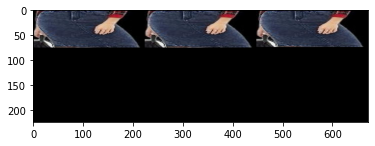

In [ ]:
plt.imshow(Show)

In [ ]:
Data1=Data1.transpose()
Data2=Data2.transpose()
Data3=Data3.transpose()
Data4=Data4.transpose()
Data5=Data5.transpose()
Data6=Data6.transpose()
Data7=Data7.transpose()
Datos3K=np.concatenate([Data1, Data2,Data3,Data4,Data5,Data6,Data7])

In [ ]:
Datos3K

array([[230, 179,  98, ..., 196, 143,  67],
       [  5,   0,   4, ...,   0,   1,   2],
       [  0,   0,   0, ...,   1,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [ ]:
print(Datos3K.shape)

(700, 451584)


In [ ]:
X =np.reshape(Datos3K,(Datos3K.shape[0],1,224,672,3))
X = X.astype('float32') / 255.
X.shape

(700, 1, 224, 672, 3)

In [ ]:
print(X.shape)

(700, 1, 224, 672, 3)


In [ ]:
Yvalues = []
for i in range(100): 
  Yvalues.append(i)
Yvalues= np.array(Yvalues)
Yvalues = np.concatenate([Yvalues, Yvalues,Yvalues,Yvalues,Yvalues,Yvalues,Yvalues])

In [ ]:
#Yvalues=Yvalues.reshape(50,1)
Yvalues.shape

(700,)

In [ ]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(Yvalues)

# Display the change for category label using one-hot encoding
print('Original label:', Yvalues[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
train_X,valid_X,train_label,valid_label = train_test_split(X,train_Y_one_hot,test_size=0.2)


In [ ]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(560, 1, 224, 672, 3) (140, 1, 224, 672, 3) (560, 100) (140, 100)


In [ ]:
num_classes=100
input_img = Input(shape=(1,224, 672, 3)) 
def encoder(input_img):
    #encoder
    #input = 224 x 672 x 3 (wide and thin) 
    x=TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 1, 224, 672, 3))(input_img)
    x=LayerNormalization()(x)
    x=TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same"))(x)
    x=LayerNormalization()(x)
    # # # # #
    x=ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True)(x)
    x=LayerNormalization()(x)
    encoded= ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True)(x)
    
    return encoded

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    den= Dropout(0.2)(den)
    den = Dense(80, activation='relu')(den)
    den= Dropout(0.2)(den)
    out = Dense(num_classes, activation='softmax')(den)
    return out

encode = encoder(input_img)
autoencoderClassifier = Model(input_img,fc(encode))

In [ ]:
for l1,l2 in zip(autoencoderClassifier.layers[:7],autoencoderClassifier.layers[0:7]):
    l1.set_weights(l2.get_weights())

In [ ]:
autoencoderClassifier.get_weights()[0][1];

In [ ]:
for layer in autoencoderClassifier.layers[0:7]:
    layer.trainable = False

In [ ]:
autoencoderClassifier.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics=['accuracy'])


In [ ]:
autoencoderClassifier.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 224, 672, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 1, 56, 168, 128)  46592     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 1, 56, 168, 128)  256       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 28, 84, 64)    204864    
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 1, 28, 84, 64)    128       
 rNormalization)                                             

In [ ]:
classify_train = autoencoderClassifier.fit(train_X, train_label, batch_size=5,epochs=20,verbose=1,validation_data=(valid_X, valid_label))


Epoch 1/20
112/112 [==============================] - 14s 32ms/step - loss: 4.5831 - accuracy: 0.0304 - val_loss: 4.2250 - val_accuracy: 0.1429
Epoch 2/20
112/112 [==============================] - 3s 23ms/step - loss: 2.8048 - accuracy: 0.3732 - val_loss: 2.7481 - val_accuracy: 0.4286
Epoch 3/20
112/112 [==============================] - 3s 24ms/step - loss: 1.1742 - accuracy: 0.7089 - val_loss: 2.0857 - val_accuracy: 0.6071
Epoch 4/20
112/112 [==============================] - 3s 23ms/step - loss: 0.6685 - accuracy: 0.8321 - val_loss: 1.9790 - val_accuracy: 0.6000
Epoch 5/20
112/112 [==============================] - 3s 23ms/step - loss: 0.3566 - accuracy: 0.9054 - val_loss: 1.7981 - val_accuracy: 0.6286
Epoch 6/20
112/112 [==============================] - 3s 24ms/step - loss: 0.4720 - accuracy: 0.9036 - val_loss: 2.1263 - val_accuracy: 0.6000
Epoch 7/20
112/112 [==============================] - 3s 24ms/step - loss: 0.3702 - accuracy: 0.9179 - val_loss: 2.0250 - val_accuracy: 0.592

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


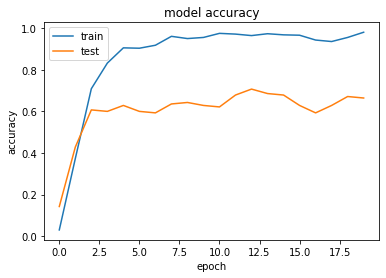

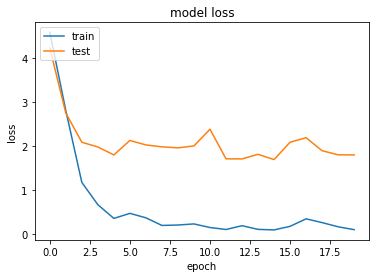

In [ ]:
print(classify_train.history.keys())
# summarize history for accuracy
plt.plot(classify_train.history['accuracy'])
plt.plot(classify_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(classify_train.history['loss'])
plt.plot(classify_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_eval = autoencoderClassifier.evaluate(valid_X, valid_label, verbose=0)


In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.7982896566390991
Test accuracy: 0.6642857193946838


In [ ]:
predicted_classes = autoencoderClassifier.predict(X)


22/22 [==============================] - 3s 97ms/step


In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


In [ ]:
predicted_classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,  0,  0,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23,  0, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38,  0, 40, 41, 42, 43, 44, 45, 46, 47, 48,  0, 50, 51, 52,
       53, 54,  0, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94,  0, 96, 97, 98, 99,  0,  1,  2,  0,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25

In [ ]:
predicted_classes.shape, Yvalues.shape


((700,), (700,))

Found 57 incorrect labels


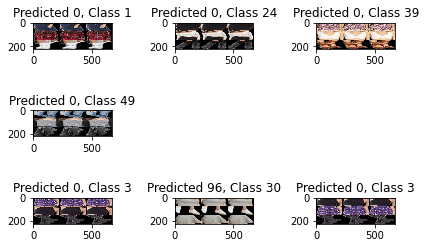

In [ ]:
incorrect = np.where(predicted_classes!=Yvalues)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X[incorrect].reshape(224,672,3), interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], Yvalues[incorrect]))
    plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(Yvalues, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.11      0.86      0.20         7
     Class 1       1.00      0.71      0.83         7
     Class 2       1.00      1.00      1.00         7
     Class 3       1.00      0.71      0.83         7
     Class 4       1.00      0.86      0.92         7
     Class 5       1.00      0.86      0.92         7
     Class 6       1.00      1.00      1.00         7
     Class 7       1.00      0.86      0.92         7
     Class 8       1.00      1.00      1.00         7
     Class 9       1.00      1.00      1.00         7
    Class 10       1.00      0.71      0.83         7
    Class 11       1.00      0.86      0.92         7
    Class 12       1.00      0.86      0.92         7
    Class 13       1.00      0.86      0.92         7
    Class 14       1.00      1.00      1.00         7
    Class 15       1.00      1.00      1.00         7
    Class 16       1.00      0.86      0.92         7
    Class 17       1.00    

In [ ]:
autoencoderClassifier.save('1.EncoderClassifierFinal.h5')